<a href="https://colab.research.google.com/github/DCBassi/Tech_Challenge_1/blob/narciso/01_exploracao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importação das bibliotecas:

In [1]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=86d46785e24d6ecf07945056553ce906d3d5845a301f46b24c7965b888913800
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from lime import lime_tabular
# Opção 2
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

Carregar os dados da análise:

In [3]:
# Carregar o dataset
df = pd.read_csv('diabetes.csv')

# Visualizar as primeiras linhas
print(df.head())

# Verificar informações básicas do dataset
print(df.info())

# Estatísticas descritivas
print(df.describe())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768

Analisando a distribuição das variáveis através de um histograma:

In [4]:
df['Outcome'].value_counts()

,count
Outcome,
0,500
1,268


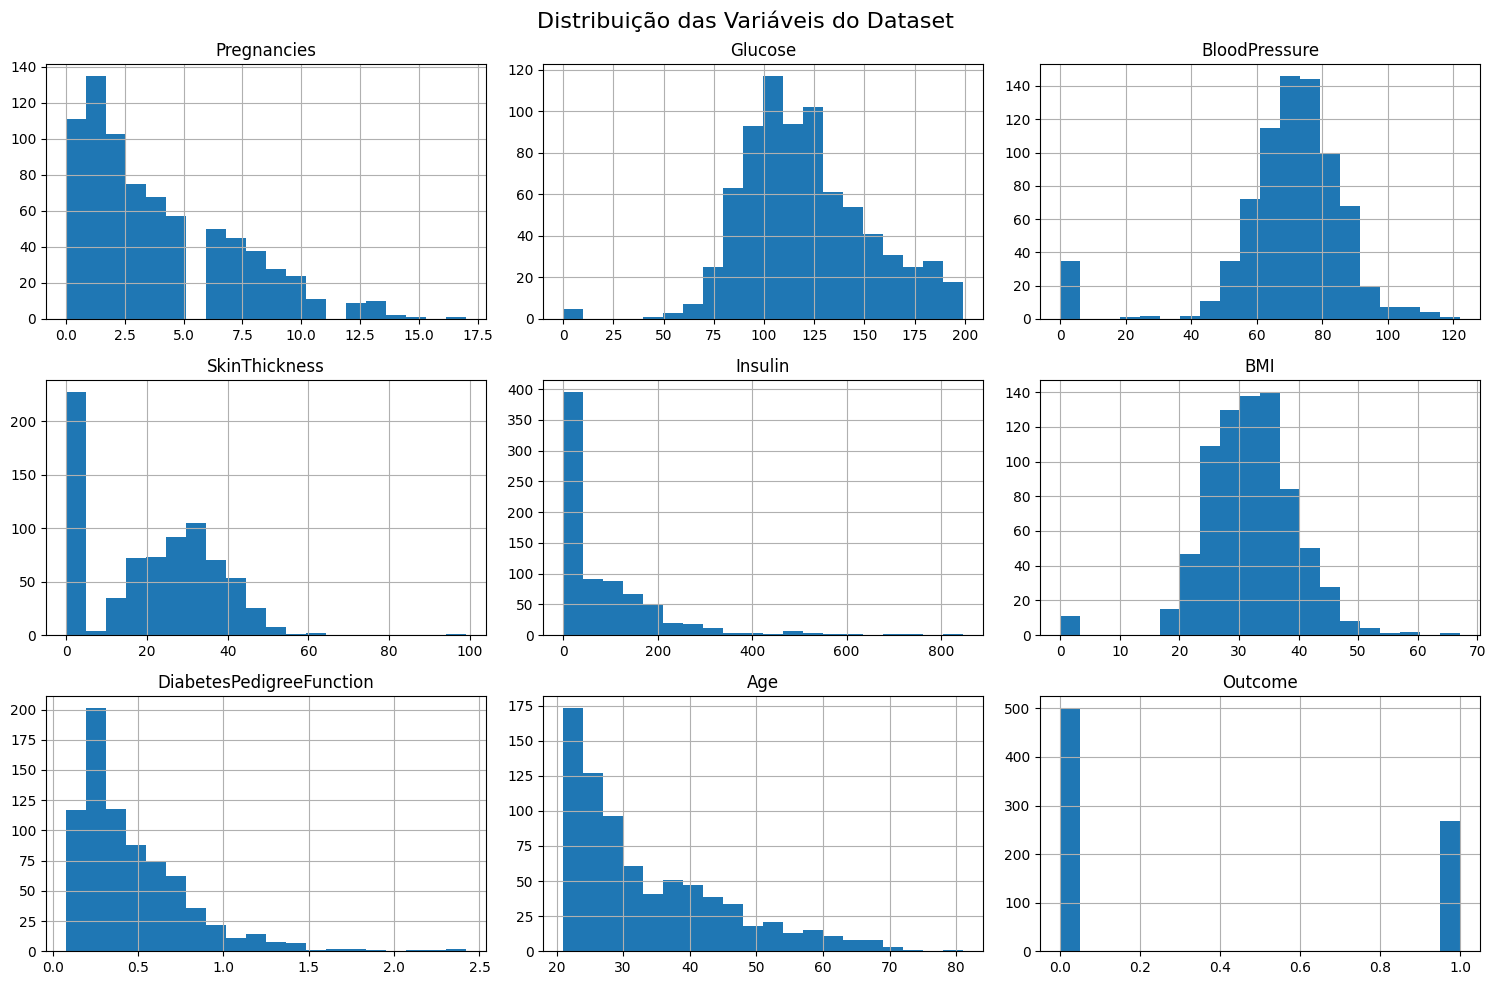

In [5]:
# Criar histogramas para ver a distribuição das variáveis
df.hist(bins=20, figsize=(15, 10))
plt.suptitle('Distribuição das Variáveis do Dataset', fontsize=16)
plt.tight_layout()
plt.show()

Analisando a correlação das variáveis:

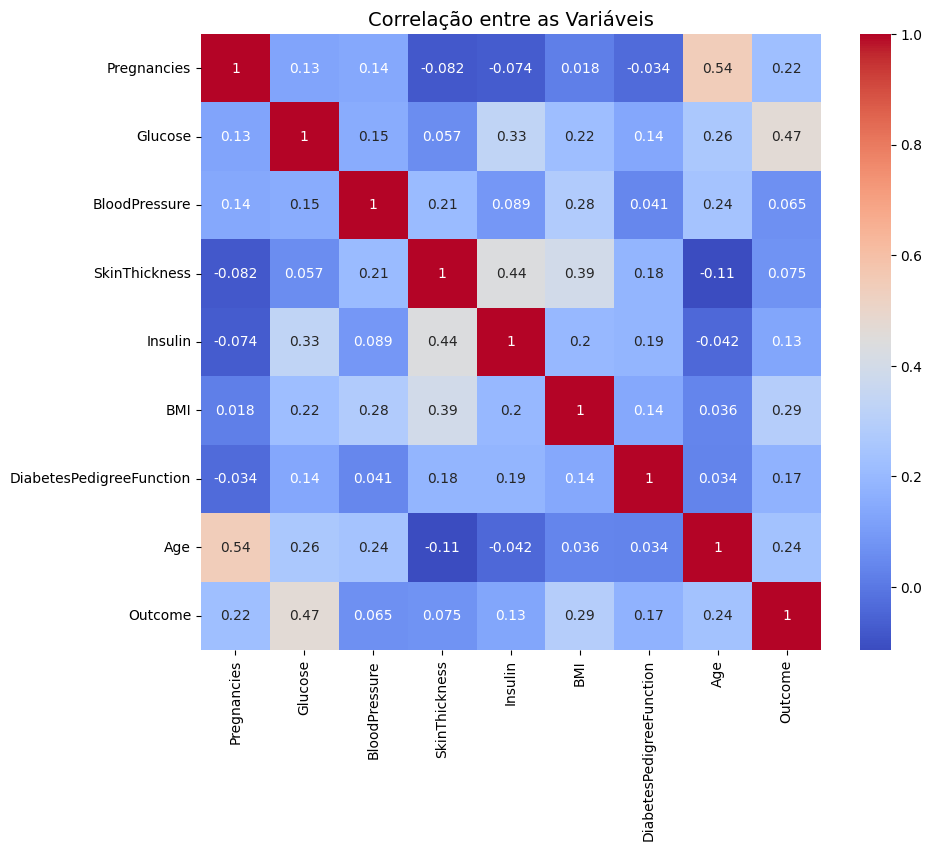

In [6]:
# Criar mapa de calor da correlação
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlação entre as Variáveis', fontsize=14)
plt.show()

Fazendo a tratativa dos zeros:

In [7]:
# Verificando a quantidade de zeros nas colunas suspeitas
colunas_problema = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for coluna in colunas_problema:
    print(f'{coluna} - quantidade de zeros: {df[coluna].value_counts().get(0, 0)}')

# Substituindo zeros pela mediana
for coluna in colunas_problema:
    df[coluna] = df[coluna].replace(0, None)

Glucose - quantidade de zeros: 5
BloodPressure - quantidade de zeros: 35
SkinThickness - quantidade de zeros: 227
Insulin - quantidade de zeros: 374
BMI - quantidade de zeros: 11


Separando variável target e entrada:

In [8]:
# Separando as variáveis de entrada e o alvo
X = df.drop('Outcome', axis=1)
Y = df['Outcome']
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2,stratify=Y, random_state=42)

Escalonando os dados:

In [9]:
# Normalizando os dados
scaler = MinMaxScaler()
X_treino_normalizado = scaler.fit_transform(X_train)
X_teste_normalizado = scaler.transform(X_test)

In [10]:
X_treino_escala = pd.DataFrame(X_treino_normalizado,columns=X_train.columns,index=X_train.index)
X_teste_escala = pd.DataFrame(X_teste_normalizado,columns=X_test.columns,index=X_test.index)

Aplicação do Imputer:

In [11]:
imputer = SimpleImputer(strategy="median")
X_treino_imputer = imputer.fit_transform(X_treino_escala)
X_teste_imputer = imputer.transform(X_teste_escala)
X_treino_completo = pd.DataFrame(X_treino_imputer,columns=X_treino_escala.columns,index=X_treino_escala.index)
X_teste_completo = pd.DataFrame(X_teste_imputer,columns=X_teste_escala.columns,index=X_teste_escala.index)

In [12]:
X_treino_completo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 614 entries, 353 to 107
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               614 non-null    float64
 1   Glucose                   614 non-null    float64
 2   BloodPressure             614 non-null    float64
 3   SkinThickness             614 non-null    float64
 4   Insulin                   614 non-null    float64
 5   BMI                       614 non-null    float64
 6   DiabetesPedigreeFunction  614 non-null    float64
 7   Age                       614 non-null    float64
dtypes: float64(8)
memory usage: 43.2 KB


Testando:

In [61]:
ros = RandomUnderSampler(random_state=42)
X_treino_final, Y_treino_final = ros.fit_resample(X_treino_completo,Y_train)
modelK = KNeighborsClassifier(n_neighbors=5)
modelK.fit(X_treino_final, Y_treino_final)
y_pred = modelK.predict(X_teste_completo)
accuracy = accuracy_score(Y_test, y_pred)
conf_matrix = confusion_matrix(Y_test, y_pred)


# Métricas
print(f"Acurácia: {accuracy_score(Y_test, y_pred):.2f}")
print(f"Precisão: {precision_score(Y_test, y_pred):.2f}")
print(f"Recall: {recall_score(Y_test, y_pred):.2f}")
print(f"F1-score: {f1_score(Y_test, y_pred):.2f}")
print("\nMatriz de Confusão:\n", confusion_matrix(Y_test, y_pred))
print("\nRelatório de Classificação:\n", classification_report(Y_test, y_pred))

Acurácia: 0.71
Precisão: 0.57
Recall: 0.72
F1-score: 0.63

Matriz de Confusão:
 [[70 30]
 [15 39]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.82      0.70      0.76       100
           1       0.57      0.72      0.63        54

    accuracy                           0.71       154
   macro avg       0.69      0.71      0.70       154
weighted avg       0.73      0.71      0.71       154



Vamos agora calcular a curva ROC para demonstrar a taxa de acerto do modelo em relação a variável alvo:

In [62]:
y_prob = modelK.predict_proba(X_teste_completo)[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

np.float64(0.7703703703703704)

Text(0.5, 0, 'False Positive Rate')

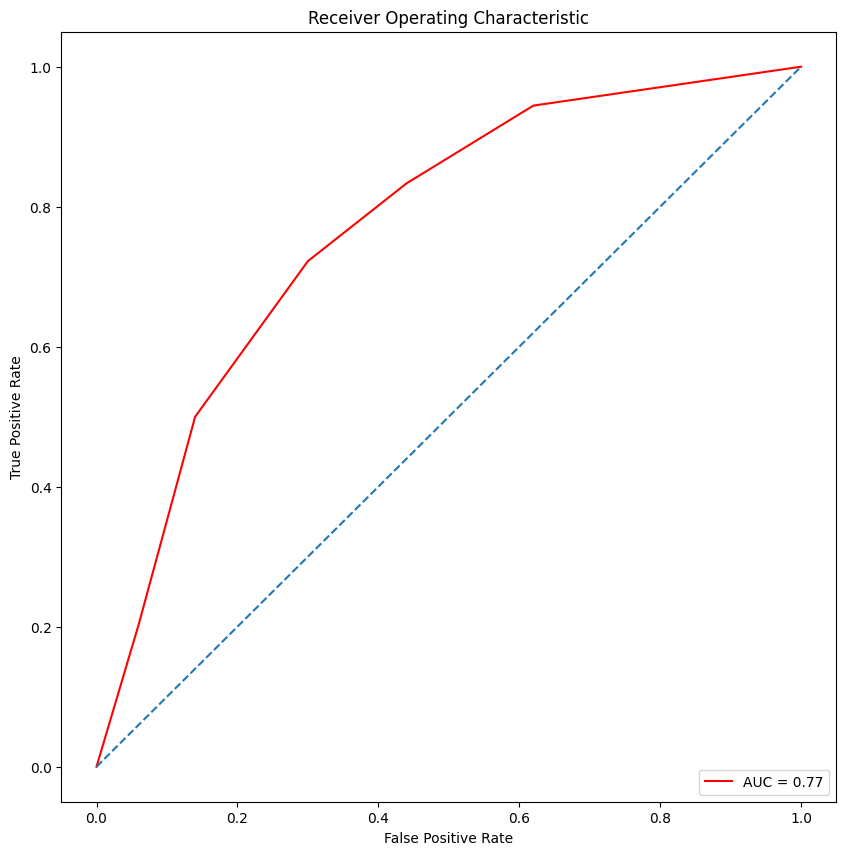

In [63]:
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

O gráfico acima, bem como os resultados de métricas anteriores, mostram que o modelo KNN tem uma taxa de acerto razoável, embora não possa ser totalmente confiável e precise de um acompanhamento maior. Isso se dá pelo fato de que o dataset analisado possuir poucas instâncias de casos de diabetes positivo, o que gera desequilíbrio e, mesmo sendo um bom modelo, não consegue entregar uma performance muito alta.

Utilizamos no próximo bloco a técnica de explicabilidade SHAP para analisar os fatores-chave do modelo:

In [64]:
background_data = shap.utils.sample(X_teste_completo, 100)

explainer = shap.KernelExplainer(modelK.predict, background_data)

shap_values = explainer.shap_values(X_teste_completo)
print(f"Valores SHAP calculados para {len(X_teste_completo)} instâncias.")
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_teste_completo.iloc[0,:])

  0%|          | 0/154 [00:00<?, ?it/s]

Valores SHAP calculados para 154 instâncias.


  0%|          | 0/154 [00:00<?, ?it/s]

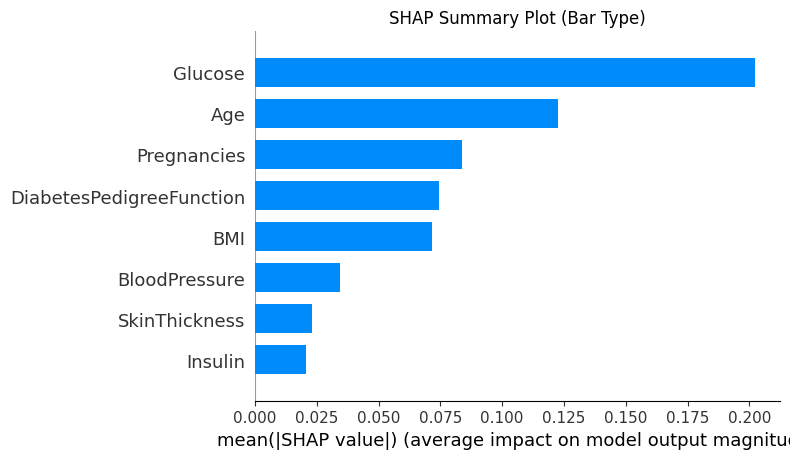

In [65]:
background_data = shap.utils.sample(X_treino_completo, 100)

explainer = shap.KernelExplainer(modelK.predict, background_data)

shap_values = explainer.shap_values(X_teste_completo)
if isinstance(shap_values, list):
    # Pega os valores SHAP para a classe positiva (classe 1 para classificação binária)
    shap_values_to_plot = shap_values[1]
else:
    shap_values_to_plot = shap_values


shap.initjs()
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_to_plot, X_test, plot_type="bar", show=False)
plt.title("SHAP Summary Plot (Bar Type)")
plt.tight_layout()

Segundo os dados acima, a glicose é o fator principal para a tomada de decisão, seguido da idade. A glicose é o principal indicador para dizer se uma pessoa possui diabetes ou não, onde um número mais alto sempre vai aumentar a probabilidade de um diagnóstico positivo. Uma idade mais avançada aumenta a probabilidade de diabetes, dado o estilo de vida da pessoa analisada. Conforme esta análise, os fatores indicados pelo modelo fazem sentido para o estudo do caso.

In [66]:
feature_names = X_treino_completo.columns.tolist()
class_names = ['No Diabetes', 'Diabetes']


explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_treino_completo.values,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)

Vamos agora testar o método LIME, para analisar os fatores de uma instância específica do modelo:

In [67]:
instance_to_explain = X_treino_completo.iloc[0]
true_label = Y_test.iloc[0]
predicted_proba = modelK.predict_proba(instance_to_explain.values.reshape(1, -1))[0]
predicted_class = np.argmax(predicted_proba)

print(f"\nExplicando a instância:")
print(instance_to_explain)
print(f"\nClasse Verdadeira: {class_names[true_label]}")
print(f"Probabilidades Previstas pelo Modelo: {predicted_proba}")
print(f"Classe Prevista pelo Modelo: {class_names[predicted_class]}")


explanation = explainer.explain_instance(
    data_row=instance_to_explain.values,
    predict_fn=modelK.predict_proba,
    num_features=5,
    top_labels=1
)

print("\nExplicação LIME gerada.")


Explicando a instância:
Pregnancies                 0.058824
Glucose                     0.237762
BloodPressure               0.387755
SkinThickness               0.054348
Insulin                     0.038409
BMI                         0.184049
DiabetesPedigreeFunction    0.220935
Age                         0.050000
Name: 353, dtype: float64

Classe Verdadeira: No Diabetes
Probabilidades Previstas pelo Modelo: [1. 0.]
Classe Prevista pelo Modelo: No Diabetes

Explicação LIME gerada.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


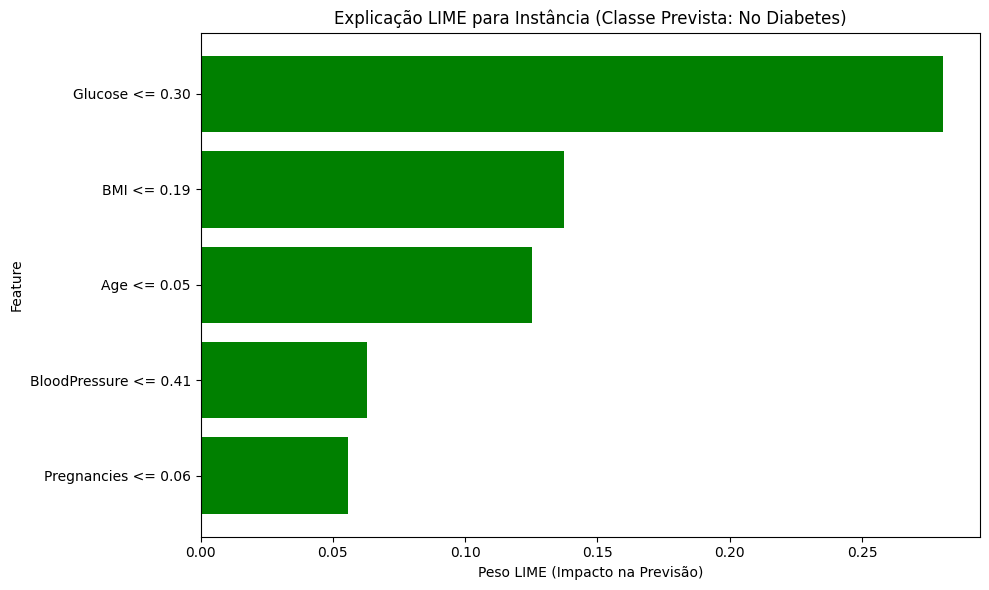

In [68]:
weights = explanation.as_list(label=predicted_class)
feature_labels = [item[0] for item in weights]
feature_values = [item[1] for item in weights]

plt.figure(figsize=(10, 6))
plt.barh(feature_labels, feature_values, color=['red' if x < 0 else 'green' for x in feature_values])
plt.xlabel('Peso LIME (Impacto na Previsão)')
plt.ylabel('Feature')
plt.title(f'Explicação LIME para Instância (Classe Prevista: {class_names[predicted_class]})')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Os dados acima reforçam as análises feitas pelo método SHAP, tendo uma pequena variação quanto aos dados de IMC e números de gravidez. Isso se dá pelo fato de que essas duas variáveis podem variar de pessoa pra pessoa e ter um peso diferente dependendo da análise. O IMC pode ser sim muito determinante para um quadro de diabetes, indicando um alto índice de gordura e, consequentemente, hábitos não saudáveis, mas não é um valor absoluto, uma vez que uma pessoa pode ter um índice de gordura baixo e ainda ter diabetes. A gravidez pode desregular os hormônios do corpo, incluindo a insulina, o que pode alterar os resultados da previsão, mas é totalmente variável de pessoa pra pessoa.

Agora, geramos estas mesmas informações para o modelo RandomForest:

In [69]:
modelR = RandomForestClassifier(random_state=42)
modelR.fit(X_treino_final, Y_treino_final)
y_pred = modelR.predict(X_teste_completo)
accuracy = accuracy_score(Y_test, y_pred)
conf_matrix = confusion_matrix(Y_test, y_pred)


# Métricas
print(f"Acurácia: {accuracy_score(Y_test, y_pred):.2f}")
print(f"Precisão: {precision_score(Y_test, y_pred):.2f}")
print(f"Recall: {recall_score(Y_test, y_pred):.2f}")
print(f"F1-score: {f1_score(Y_test, y_pred):.2f}")
print("\nMatriz de Confusão:\n", confusion_matrix(Y_test, y_pred))
print("\nRelatório de Classificação:\n", classification_report(Y_test, y_pred))

Acurácia: 0.73
Precisão: 0.59
Recall: 0.78
F1-score: 0.67

Matriz de Confusão:
 [[71 29]
 [12 42]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.86      0.71      0.78       100
           1       0.59      0.78      0.67        54

    accuracy                           0.73       154
   macro avg       0.72      0.74      0.72       154
weighted avg       0.76      0.73      0.74       154



In [70]:
y_prob = modelR.predict_proba(X_teste_completo)[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

np.float64(0.8157407407407408)

Text(0.5, 0, 'False Positive Rate')

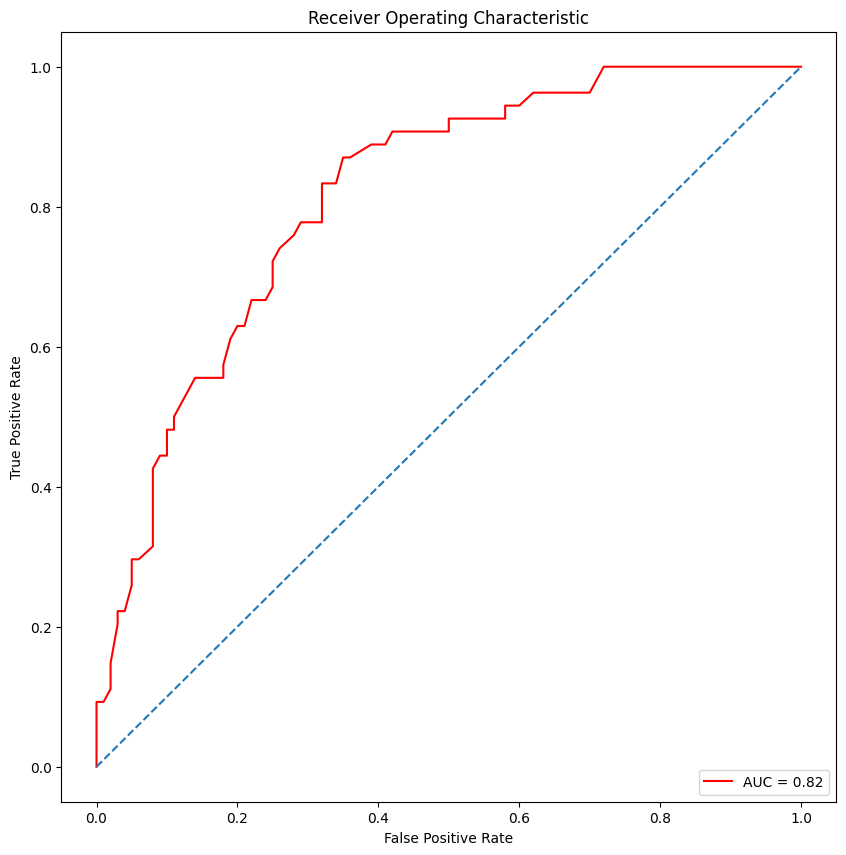

In [71]:
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [72]:
background_data = shap.utils.sample(X_treino_completo, 100)

explainer = shap.KernelExplainer(modelR.predict, background_data)

shap_values = explainer.shap_values(X_teste_completo)
print(f"Valores SHAP calculados para {len(X_teste_completo)} instâncias.")
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_teste_completo.iloc[0,:])

  0%|          | 0/154 [00:00<?, ?it/s]

Valores SHAP calculados para 154 instâncias.


  0%|          | 0/154 [00:00<?, ?it/s]

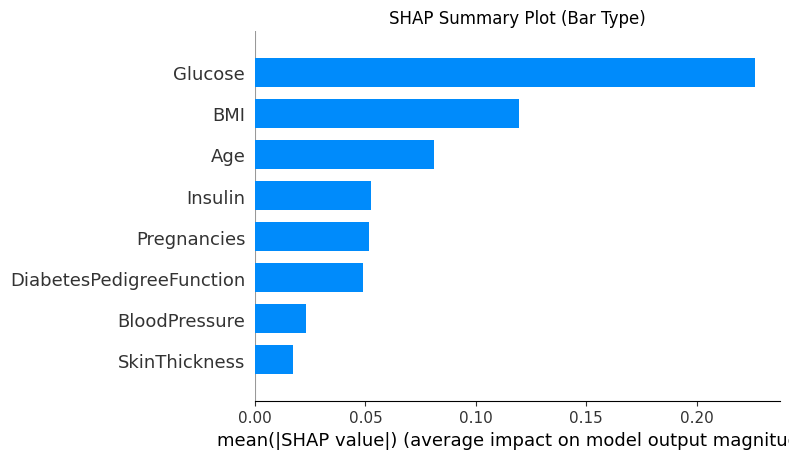

In [73]:
background_data = shap.utils.sample(X_treino_completo, 100)

explainer = shap.KernelExplainer(model.predict, background_data)

shap_values = explainer.shap_values(X_teste_completo)
if isinstance(shap_values, list):
    shap_values_to_plot = shap_values[1]
else:
    shap_values_to_plot = shap_values


shap.initjs()
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_to_plot, X_test, plot_type="bar", show=False)
plt.title("SHAP Summary Plot (Bar Type)")
plt.tight_layout()

In [74]:
feature_names = X_treino_completo.columns.tolist()
class_names = ['No Diabetes', 'Diabetes']


explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_treino_completo.values,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)

In [75]:
instance_to_explain = X_treino_completo.iloc[0]
true_label = Y_test.iloc[0]
predicted_proba = modelR.predict_proba(instance_to_explain.values.reshape(1, -1))[0]
predicted_class = np.argmax(predicted_proba)

print(f"\nExplicando a instância:")
print(instance_to_explain)
print(f"\nClasse Verdadeira: {class_names[true_label]}")
print(f"Probabilidades Previstas pelo Modelo: {predicted_proba}")
print(f"Classe Prevista pelo Modelo: {class_names[predicted_class]}")


explanation = explainer.explain_instance(
    data_row=instance_to_explain.values,
    predict_fn=modelR.predict_proba,
    num_features=5,
    top_labels=1
)

print("\nExplicação LIME gerada.")


Explicando a instância:
Pregnancies                 0.058824
Glucose                     0.237762
BloodPressure               0.387755
SkinThickness               0.054348
Insulin                     0.038409
BMI                         0.184049
DiabetesPedigreeFunction    0.220935
Age                         0.050000
Name: 353, dtype: float64

Classe Verdadeira: No Diabetes
Probabilidades Previstas pelo Modelo: [0.95 0.05]
Classe Prevista pelo Modelo: No Diabetes

Explicação LIME gerada.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


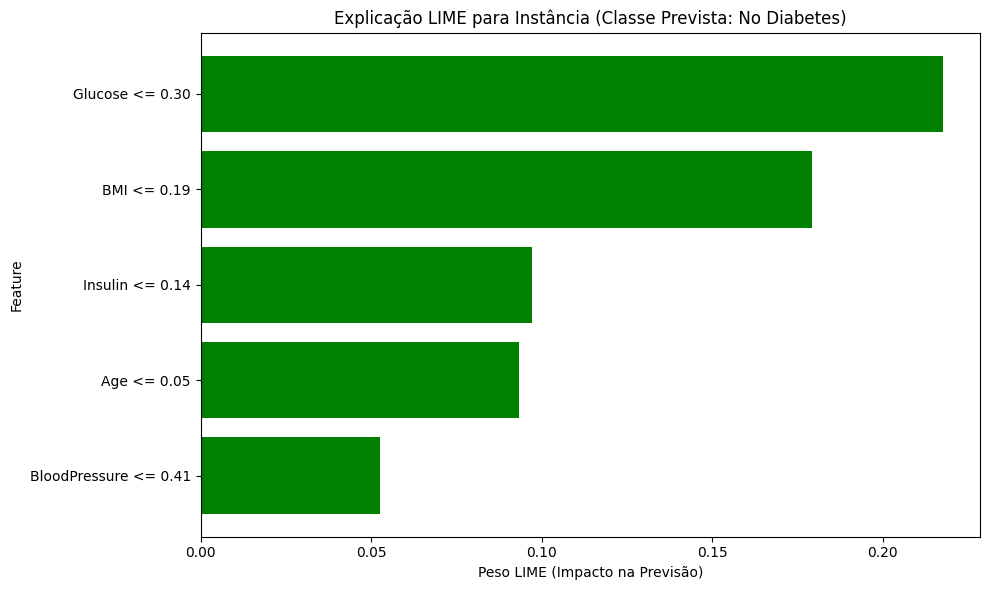

In [76]:
weights = explanation.as_list(label=predicted_class)
feature_labels = [item[0] for item in weights]
feature_values = [item[1] for item in weights]

plt.figure(figsize=(10, 6))
plt.barh(feature_labels, feature_values, color=['red' if x < 0 else 'green' for x in feature_values])
plt.xlabel('Peso LIME (Impacto na Previsão)')
plt.ylabel('Feature')
plt.title(f'Explicação LIME para Instância (Classe Prevista: {class_names[predicted_class]})')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Conforme observado acima, o modelo RandomForest e o KNN tiveram resultados muito semelhantes, tendo uma pequena variação na curva ROC e no peso do IMC no método SHAP, além de um peso um pouco menor pra idade e um pouco maior para insulina. Vamos testar o método LogisticRegression para ver como ele se sai neste cenário:

In [77]:
modelL = LogisticRegression()
modelL.fit(X_treino_final, Y_treino_final)
y_pred = modelL.predict(X_teste_completo)
accuracy = accuracy_score(Y_test, y_pred)
conf_matrix = confusion_matrix(Y_test, y_pred)


# Métricas
print(f"Acurácia: {accuracy_score(Y_test, y_pred):.2f}")
print(f"Precisão: {precision_score(Y_test, y_pred):.2f}")
print(f"Recall: {recall_score(Y_test, y_pred):.2f}")
print(f"F1-score: {f1_score(Y_test, y_pred):.2f}")
print("\nMatriz de Confusão:\n", confusion_matrix(Y_test, y_pred))
print("\nRelatório de Classificação:\n", classification_report(Y_test, y_pred))

Acurácia: 0.71
Precisão: 0.58
Recall: 0.69
F1-score: 0.63

Matriz de Confusão:
 [[73 27]
 [17 37]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.81      0.73      0.77       100
           1       0.58      0.69      0.63        54

    accuracy                           0.71       154
   macro avg       0.69      0.71      0.70       154
weighted avg       0.73      0.71      0.72       154



In [78]:
y_prob = modelL.predict_proba(X_teste_completo)[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

np.float64(0.8088888888888889)

Text(0.5, 0, 'False Positive Rate')

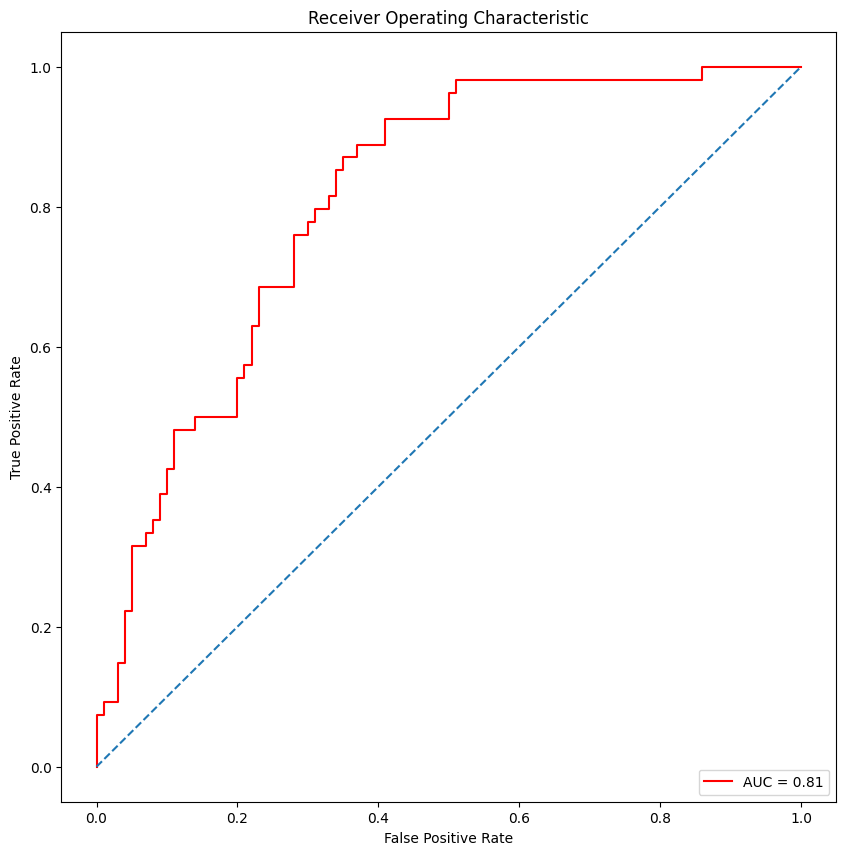

In [79]:
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [80]:
background_data = shap.utils.sample(X_treino_completo, 100)

explainer = shap.KernelExplainer(modelL.predict, background_data)

shap_values = explainer.shap_values(X_teste_completo)
print(f"Valores SHAP calculados para {len(X_teste_completo)} instâncias.")
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_teste_completo.iloc[0,:])

  0%|          | 0/154 [00:00<?, ?it/s]

Valores SHAP calculados para 154 instâncias.


  0%|          | 0/154 [00:00<?, ?it/s]

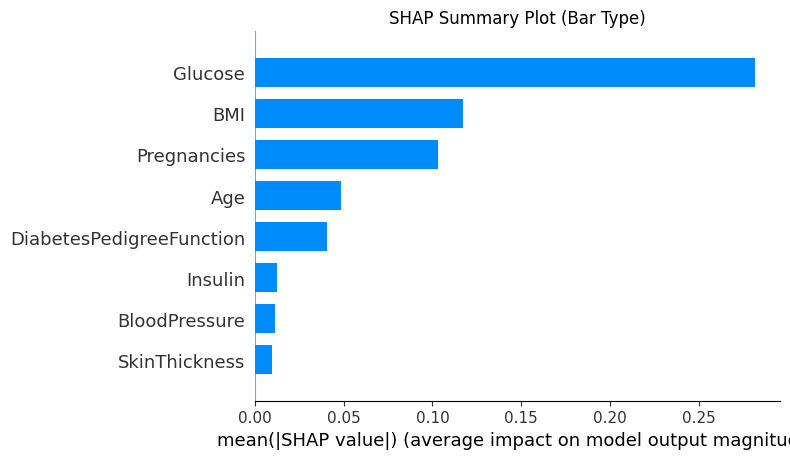

In [81]:
background_data = shap.utils.sample(X_treino_completo, 100)

explainer = shap.KernelExplainer(modelL.predict, background_data)

shap_values = explainer.shap_values(X_teste_completo)
if isinstance(shap_values, list):
    shap_values_to_plot = shap_values[1]
else:
    shap_values_to_plot = shap_values


shap.initjs()
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_to_plot, X_test, plot_type="bar", show=False)
plt.title("SHAP Summary Plot (Bar Type)")
plt.tight_layout()

In [82]:
feature_names = X_treino_completo.columns.tolist()
class_names = ['No Diabetes', 'Diabetes']


explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_treino_completo.values,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)

In [83]:
instance_to_explain = X_treino_completo.iloc[0]
true_label = Y_test.iloc[0]
predicted_proba = modelL.predict_proba(instance_to_explain.values.reshape(1, -1))[0]
predicted_class = np.argmax(predicted_proba)

print(f"\nExplicando a instância:")
print(instance_to_explain)
print(f"\nClasse Verdadeira: {class_names[true_label]}")
print(f"Probabilidades Previstas pelo Modelo: {predicted_proba}")
print(f"Classe Prevista pelo Modelo: {class_names[predicted_class]}")


explanation = explainer.explain_instance(
    data_row=instance_to_explain.values,
    predict_fn=modelL.predict_proba,
    num_features=5,
    top_labels=1
)

print("\nExplicação LIME gerada.")


Explicando a instância:
Pregnancies                 0.058824
Glucose                     0.237762
BloodPressure               0.387755
SkinThickness               0.054348
Insulin                     0.038409
BMI                         0.184049
DiabetesPedigreeFunction    0.220935
Age                         0.050000
Name: 353, dtype: float64

Classe Verdadeira: No Diabetes
Probabilidades Previstas pelo Modelo: [0.86381969 0.13618031]
Classe Prevista pelo Modelo: No Diabetes

Explicação LIME gerada.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


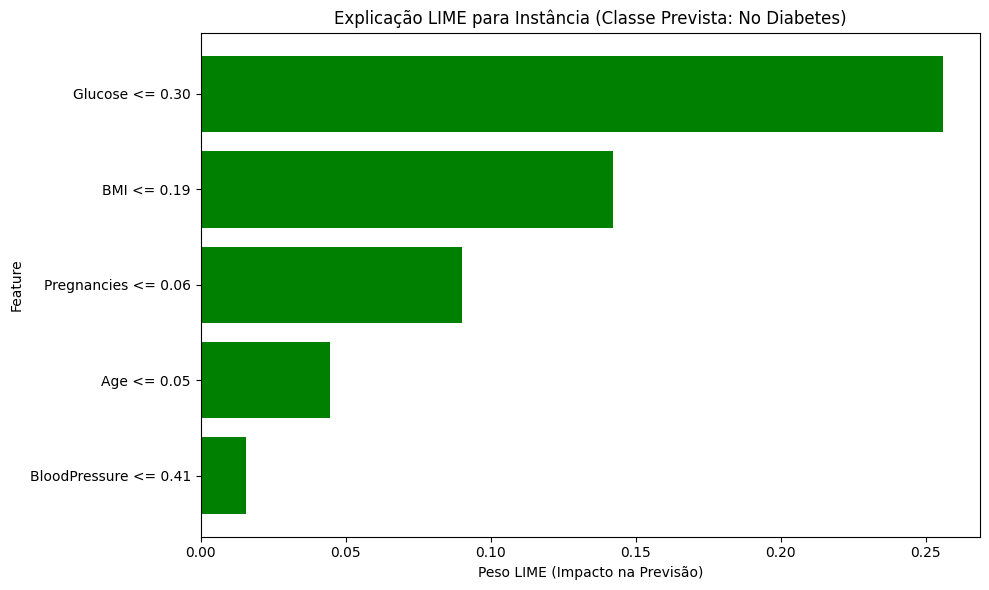

In [84]:
weights = explanation.as_list(label=predicted_class)
feature_labels = [item[0] for item in weights]
feature_values = [item[1] for item in weights]

plt.figure(figsize=(10, 6))
plt.barh(feature_labels, feature_values, color=['red' if x < 0 else 'green' for x in feature_values])
plt.xlabel('Peso LIME (Impacto na Previsão)')
plt.ylabel('Feature')
plt.title(f'Explicação LIME para Instância (Classe Prevista: {class_names[predicted_class]})')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

O modelo de regressão Logística também apresentou resultados similares. Por fim, podemos concluir que todos os modelos tem a glicose como seu principal elemento, o que faz total sentido dado a previsão que estamos tentando fazer. O modelo pode ser muito útil em gerar alertas para possíveis quadros de diabetes, auxiliando na triagem deste diagnóstico. Porém, devido a sua performance limitada, a atenção do médico deve ser um pouco maior para este modelo, sendo sempre a palavra do médico humano a definitiva. Em uma aplicação prática, poderíamos sugerir mais entradas de dados, principalmente dados de pacientes com diabetes, para alimentar este modelo e melhorar a performance.